In [1]:
import pandas as pd
import geopandas as gpd
from matplotlib import pyplot as plt
import numpy as np
import contextily
import rasterio
from rasterio.transform import from_origin
from rasterio.plot import show as rio_show
from mpl_toolkits.axes_grid1 import make_axes_locatable 

In [2]:
SA2 = gpd.read_file('../data/SA2_2021_AUST_SHP_GDA2020/SA2_2021_AUST_GDA2020.shp')
SA2 = SA2.to_crs("EPSG:7855")
SA2 = SA2[SA2['GCC_NAME21'] == "Greater Melbourne"]
SA2 = SA2[['SA2_NAME21', 'geometry']]

In [3]:
pred_demand = pd.read_csv('../output/demand_predictions.csv')

In [4]:
SA2_pred_demand = pd.merge(SA2, pred_demand, left_on='SA2_NAME21', right_on='SA2', how='inner')
centroid = SA2_pred_demand.centroid
SA2_pred_demand.drop(['SA2_NAME21', 'geometry'], axis=1)
SA2_pred_demand['geometry'] = centroid

SA2_pred_demand = gpd.GeoDataFrame(
    SA2_pred_demand, 
    geometry=gpd.points_from_xy(SA2_pred_demand.geometry.x, SA2_pred_demand.geometry.y)
)
SA2_pred_demand.crs = 'epsg:7855'

In [5]:
SA2_pred_demand['log_total'] = np.log(SA2_pred_demand['total_demand'])

In [6]:
GCCSA = gpd.read_file('../data/GCCSA_2021_AUST_SHP_GDA2020/GCCSA_2021_AUST_GDA2020.shp')
post_covid_stations = gpd.read_file('../data/curated/stations_postcovid.gpkg')
GCCSA = GCCSA.to_crs("EPSG:7855")
GreaterMelbourne = GCCSA[GCCSA['GCC_NAME21'] == 'Greater Melbourne']

In [10]:
SA2_pred_demand.sort_values('log_total', ascending=False)

,SA2_NAME21,geometry,SA2,log_demand_weekday,log_demand_weekend,demand_weekday,demand_weekend,total_demand,log_total
22,Balwyn North,POINT (331289.272 5815547.154),Balwyn North,1.194438,1.008944,10215.963015,7330.101385,9391.431121,9.147553
5,Carlton,POINT (321086.983 5814374.362),Carlton,0.914382,0.741316,6188.918887,4540.507520,5717.944211,8.651365
20,Fitzroy,POINT (322086.274 5814337.138),Fitzroy,0.931960,0.530993,6386.695638,3116.281262,5452.291531,8.603791
10,West Melbourne - Residential,POINT (319518.245 5813443.034),West Melbourne - Residential,0.809582,0.600761,5130.525351,3530.709335,4673.435061,8.449650
46,Heidelberg West,POINT (327874.890 5820904.804),Heidelberg West,0.810143,0.505544,5135.676306,2977.539420,4519.065767,8.416061
...,...,...,...,...,...,...,...,...,...
176,Rockbank - Mount Cottrell,POINT (294510.416 5818208.061),Rockbank - Mount Cottrell,-1.557709,-1.549467,74.174664,75.276864,74.489578,4.310659
200,Tarneit - South,POINT (294228.541 5807388.302),Tarneit - South,-1.529762,-1.679194,77.978871,59.680897,72.750879,4.287041
197,Tarneit (West) - Mount Cottrell,POINT (290910.602 5811030.458),Tarneit (West) - Mount Cottrell,-1.600480,-1.685234,68.708909,59.039214,65.946139,4.188838
187,Melton,POINT (288004.872 5826331.782),Melton,-1.743989,-1.724961,53.146551,54.987573,53.672558,3.982902


Text(0.5, 1.0, 'Estimated Train Demand In Each SA2')

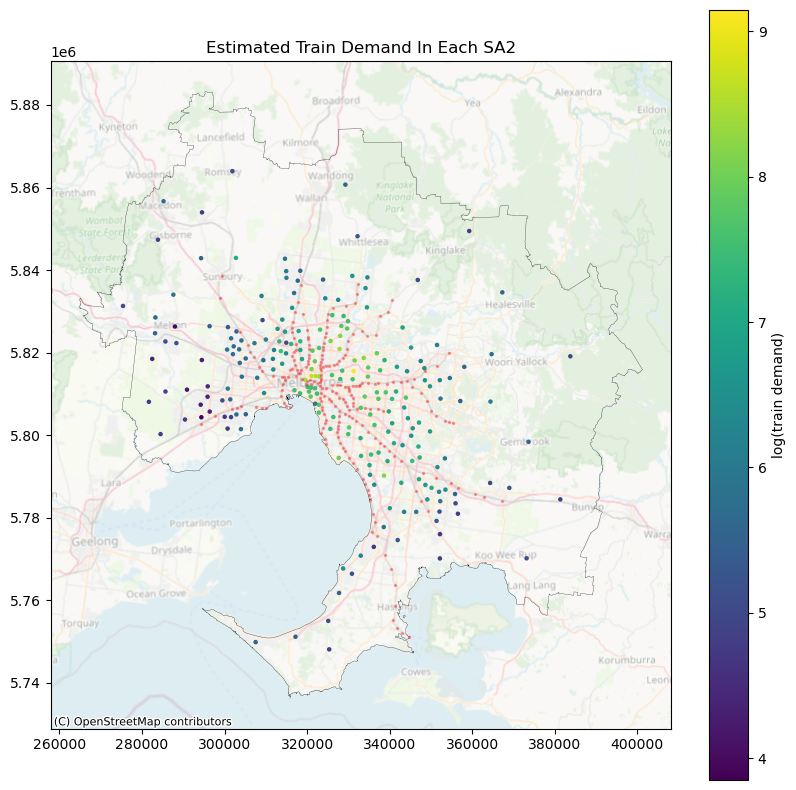

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
SA2_pred_demand.plot(column='log_total',
                ax=ax,
                legend=True,
                legend_kwds={'label': "log(train demand)",'orientation': "vertical"},
                markersize=5)

#SA2.plot(ax=ax, facecolor='None', linewidth=0.1)
GreaterMelbourne.plot(ax=ax, facecolor='None', linewidth=0.2)

post_covid_stations.plot(ax=ax,markersize=2, color='red', alpha=0.3)

contextily.add_basemap(ax=ax, 
                       crs = SA2_pred_demand.crs.to_string(), 
                       source = contextily.providers.OpenStreetMap.Mapnik, 
                       alpha=0.4)

ax.set_title('Estimated Train Demand In Each SA2')

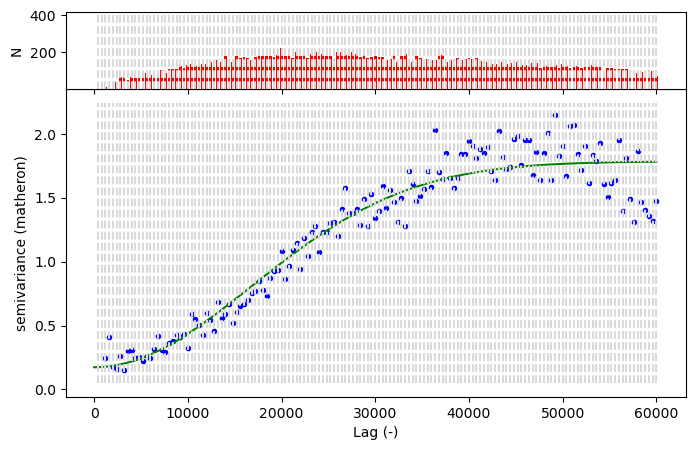

In [28]:
import skgstat
SA2_pred_demand['x'] = SA2_pred_demand.geometry.x.round(3)
SA2_pred_demand['y'] = SA2_pred_demand.geometry.y.round(3)
coords = SA2_pred_demand[['x', 'y']].values
demands = SA2_pred_demand['log_total'].values
V = skgstat.Variogram(coordinates = coords, values = demands, 
                      model = 'Gaussian', n_lags = 150,
                      maxlag = 60000,  use_nugget = True)

fig = V.plot(show = False)

In [33]:
# Fit variogram model
import math
ok = skgstat.OrdinaryKriging(V, min_points = 5, max_points = 20, mode='exact')
grid_size = 1000
vic_bounds = GreaterMelbourne.bounds
minX = vic_bounds.minx.values[0]
minY = vic_bounds.miny.values[0]
maxX = vic_bounds.maxx.values[0]
maxY = vic_bounds.maxy.values[0]
x_spacing = np.arange(minX, maxX, grid_size)
y_spacing = np.arange(minY, maxY, grid_size)
gridX, gridY = np.meshgrid(x_spacing, y_spacing)
interp_arr = ok.transform(gridX.flatten(), gridY.flatten()).reshape(gridX.shape)
# the Kriging error
interp_err_arr = ok.sigma.reshape(gridX.shape)
affine = from_origin(west = gridX[0][0], north = gridY[-1][0], xsize = grid_size, ysize = grid_size)

height = math.ceil((maxY - minY)/grid_size)
width = math.ceil((maxX - minX)/grid_size)
filename = '../output/kriging.tif'
with rasterio.open(filename,
                    'w', 
                    driver = 'GTiff', 
                    dtype = np.float32,
                    count = 1,
                    width=width,
                    height=height,
                    crs = 'EPSG:7855', 
                    transform = affine) as ds_out:

        ds_out.write(np.flip(interp_arr, axis = 0), 1)


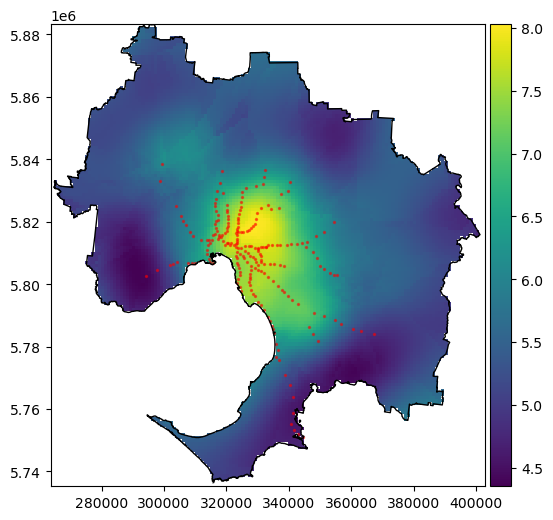

In [34]:
import rasterio.mask

with rasterio.open('../output/kriging.tif', 'r') as ras:
    profile = ras.profile
    masked_ras, masked_ras_transform = rasterio.mask.mask(dataset = ras, 
                                                          shapes = GreaterMelbourne.geometry, 
                                                          nodata = np.NaN, 
                                                          crop = True)
masked_ras_profile = profile.copy()
masked_ras_profile['height'] = masked_ras.shape[1]
masked_ras_profile['width'] = masked_ras.shape[2]
masked_ras_profile['transform'] = masked_ras_transform

temp_raster_file = '../output/kriging_masked.tif'

with rasterio.open(temp_raster_file, 'w', **masked_ras_profile) as ds_out:
    ds_out.write(masked_ras)

with rasterio.open(temp_raster_file, 'r') as ds:
    img_arr = ds.read(1)

# assigning nodata value as NaN
img_arr[img_arr == ds.nodata] = np.NaN

fig, ax = plt.subplots(figsize = (8, 6))

divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)

im = rasterio.plot.show(img_arr, ax = ax, transform = ds.transform) # cmap = 'viridis'
im = im.get_images()[0]
fig.colorbar(im, cax=cax, orientation='vertical')

post_covid_stations.plot(ax=ax, color='red', alpha=0.5, markersize=2)
GreaterMelbourne.plot(ax=ax, facecolor='None')
# set the plot boundary to dataset.bounds
n = 1
ax.set_xlim(ds.bounds.left - n*grid_size, ds.bounds.right + n*grid_size)
ax.set_ylim(ds.bounds.bottom - n*grid_size, ds.bounds.top + n*grid_size)


plt.show()
